In [1]:
# Load local libraries
import __load_libs
from src.df_io import from_csv, to_csv
from src.df_stats import get_outliers_iqr

import matplotlib.pyplot as plt

# Problem 3. Data cleaning and preprocessing

Load the last state of the data.

In [2]:
patients_df = from_csv('../data/02_data_explored.csv')
patients_df.head()

,patient_id,age,gender,ethnicity,education_level,bmi,smoking,physical_activity,diet_quality,sleep_quality,...,lung_function_fvc,wheezing,shortness_of_breath,chest_tightness,coughing,nighttime_symptoms,exercise_induced,diagnosis,doctor_in_charge,fev1_fvc_ratio
0,5034,63,0,1,0,15.848744,0,0.8944483090233335,5.488695584993768,8.701002733591553,...,4.941206,0,0,1,0,0,1,0,Dr_Confid,0.277068
1,5035,26,1,2,2,22.757042,0,5.897329493528446,6.341014020966575,5.153966369546168,...,1.702393,1,0,0,1,1,1,0,Dr_Confid,1.290987
2,5036,57,0,2,1,18.395396,0,6.739367010951074,9.196237204622909,6.840646602827763,...,5.022553,1,1,1,0,1,1,0,Dr_Confid,0.338077
3,5037,40,1,2,1,38.515278,0,1.4045026784207648,5.826531797560653,4.25303551230768,...,2.300159,1,0,1,1,1,0,0,Dr_Confid,1.318186
4,5038,61,0,0,3,19.283802,0,4.6044926148128855,3.127048193671432,9.625799205296698,...,3.067944,1,1,1,0,0,1,0,Dr_Confid,1.131243


In [3]:
patients_df.dtypes

patient_id                    int64
age                           int64
gender                     category
ethnicity                  category
education_level            category
bmi                         float64
smoking                    category
physical_activity          category
diet_quality               category
sleep_quality              category
pollution_exposure         category
pollen_exposure            category
dust_exposure              category
pet_allergy                category
family_history_asthma      category
history_of_allergies       category
eczema                     category
hay_fever                  category
gastroesophageal_reflux    category
lung_function_fev1          float64
lung_function_fvc           float64
wheezing                   category
shortness_of_breath        category
chest_tightness            category
coughing                   category
nighttime_symptoms         category
exercise_induced           category
diagnosis                  c

## NA values

Let's check for NA values.

In [4]:
patients_df.isna().sum()

patient_id                 0
age                        0
gender                     0
ethnicity                  0
education_level            0
bmi                        0
smoking                    0
physical_activity          0
diet_quality               0
sleep_quality              0
pollution_exposure         0
pollen_exposure            0
dust_exposure              0
pet_allergy                0
family_history_asthma      0
history_of_allergies       0
eczema                     0
hay_fever                  0
gastroesophageal_reflux    0
lung_function_fev1         0
lung_function_fvc          0
wheezing                   0
shortness_of_breath        0
chest_tightness            0
coughing                   0
nighttime_symptoms         0
exercise_induced           0
diagnosis                  0
doctor_in_charge           0
fev1_fvc_ratio             0
dtype: int64

* **OBSERVATION**: No NA values observed in the dataset. That's great!

## Duplicated values
Let's check for duplicated rows.

In [5]:
patients_df.duplicated().sum()

np.int64(0)

* **OBSERVATION**: No duplicates. That's good.

## Drop `doctor_in_charge`

* **OBSERVATION**: Column `doctor_in_charge` does not look to bring any value. It has a **single** value. Furthermore, that value is `Dr_Confid` (i.e. anonymized). 

Let's drop it.

In [6]:
patients_df = patients_df.drop(columns=['doctor_in_charge'])

## Drop `patient_id`

In [7]:
patients_df.patient_id.nunique()

2392

* **OBSERVATION**: `patient_id` identifier covers all values between $5034$ and $7425$. Hmm, what about values below $5034$? Or above $7425$?
* **ACTION**: I tried to find related data (e.g. more patients). Unfortunately, I wasn't able to find such.

So, I see no point in keeping this identifier further. It will not be needed for training a prediction model.

In [8]:
patients_df = patients_df.drop(columns=['patient_id'])

## Outliers

Look for outliers in all `float` columns.

In [9]:
bmi_outliers = get_outliers_iqr(patients_df, 'bmi')
bmi_outliers.shape

(0, 28)

In [10]:
lung_function_fev1_outliers = get_outliers_iqr(patients_df, 'lung_function_fev1')
lung_function_fev1_outliers.shape

(0, 28)

In [11]:
lung_function_fev1_outliers = get_outliers_iqr(patients_df, 'lung_function_fvc')
lung_function_fev1_outliers.shape

(0, 28)

## FEV1/FVC ratio

The FEV1/FVC ratio is the ratio of the forced expiratory volume in the first one second to the forced vital capacity of the lungs. The normal value for this ratio is above $.85$, though this is age dependent.

**FEV1/FVC Ratio Severity of Condition**: Under 70% Mild, 60 to 69% Moderate, 50 to 9% Moderately severe, 35 to 49% Severe, Under 34% Very severe.

Extreme values should not exceed 120%. Therefore, should be excluded as data error.

In [12]:
# Creating a new variable for FEV1/FVC ratio
patients_df['fev1_fvc_ratio'] = patients_df['lung_function_fev1'].astype(float) / patients_df['lung_function_fvc'].astype(float)
patients_df['fev1_fvc_ratio'].describe()

count    2392.000000
mean        0.788666
std         0.440339
min         0.171552
25%         0.470483
50%         0.676843
75%         0.981560
max         2.577281
Name: fev1_fvc_ratio, dtype: float64

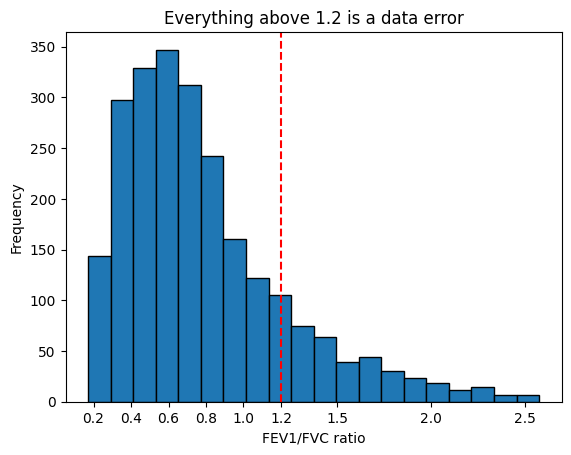

In [13]:
# Plot the distribution of the fev1_fvc_ratio
plt.hist(patients_df['fev1_fvc_ratio'], bins=20, edgecolor='black')
plt.title('Everything above 1.2 is a data error')
plt.xlabel('FEV1/FVC ratio')
plt.ylabel('Frequency')
plt.axvline(x=1.2, color='red', linestyle='--')
plt.xticks([0.2, 0.4,0.6, 0.8, 1, 1.2, 1.5, 2.0, 2.5])
plt.show()

* **OBSERVATION**: We have extremely high values (exceeding $1.20$). Hence, we need to remove them.

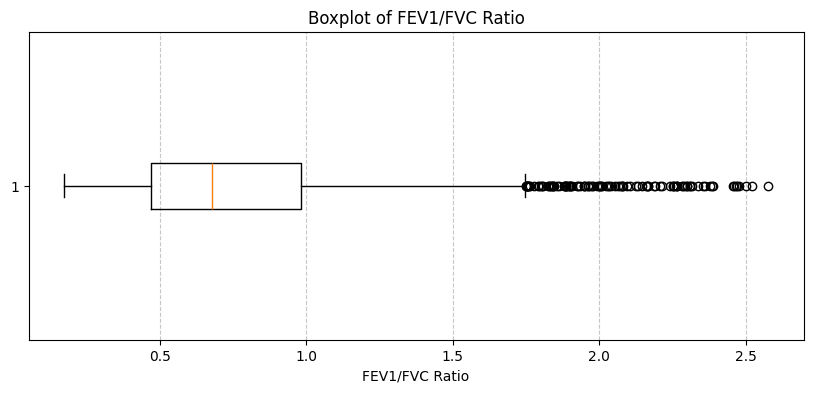

In [14]:
# Plotting boxplot for FEV1/FVC ratio to identify outliers
plt.figure(figsize=(10, 4))
plt.boxplot(patients_df['fev1_fvc_ratio'], vert=False)
plt.xlabel('FEV1/FVC Ratio')
plt.title('Boxplot of FEV1/FVC Ratio')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Let's check what part of these ratios are actually outliers (not feeling guilty about removing them) :D

In [15]:
fev1_fvc_ratio_outliers = get_outliers_iqr(patients_df, 'fev1_fvc_ratio')
print(f"Number of outliers: {fev1_fvc_ratio_outliers.shape[0]}")

Number of outliers: 106


In [16]:
print(f"Number of extremely high ratios: {patients_df[patients_df['fev1_fvc_ratio'] > 1.2].shape[0]}")

Number of extremely high ratios: 375


Let's drop these rows. :(

In [17]:
# Dropping the rows where FEV1_FVC_ratio is greater than 1.2
patients_df = patients_df[patients_df['fev1_fvc_ratio'] <= 1.2]
patients_df.shape

(2017, 28)

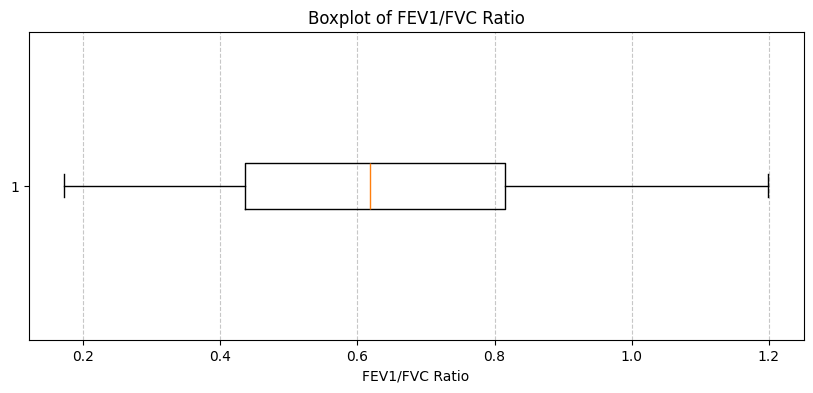

In [18]:
# Plotting boxplot for FEV1/FVC ratio to identify outliers
plt.figure(figsize=(10, 4))
plt.boxplot(patients_df['fev1_fvc_ratio'], vert=False)
plt.xlabel('FEV1/FVC Ratio')
plt.title('Boxplot of FEV1/FVC Ratio')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

It looks good now! :)

## Persist output

We should persist the current state of the dataframe to a file on the OS.

In [19]:
patients_df.shape

(2017, 28)

In [20]:
to_csv(patients_df, '../data/03_data_cleaned.csv')